In [1]:
import io
#npx degit jghawaly/CSC7809_FoundationModels/Project2/data/raw raw/                             
import os, glob
from typing import Tuple
import numpy as np
import torch
import numpy as np
from functools import reduce
import sentencepiece as spm
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW, lr_scheduler
from torcheval.metrics.metric import Metric
from torcheval.metrics.text import Perplexity, BLEUScore
import json
from tqdm import tqdm
from datetime import datetime
from word_prediction import TokenizedDataset, read_jsonl, add_special_token, training_kit, mkcollation, evaluate_perplexity
from models import TransformerModel

In [2]:
tokenizer_location = "bptokenizer.model"
training_data = read_jsonl('./data/train.jsonl')
testing_data = read_jsonl('./data/test.jsonl')
sp = spm.SentencePieceProcessor(tokenizer_location)

embed_dim=128
output_size=sp.GetPieceSize()
feedforward_size=512
batch_size=64
seq_len = 45  # Length of the input sequence


In [3]:

if torch.cuda.is_available():
    print('torch cuda is_available')
    device = torch.device('cuda')          # Use GPU
else:
    print('torch cuda not is_available')
    device = torch.device('cpu')           # Use CPU
    
metrics = {
    'perp': Perplexity(ignore_index=sp.pad_id()).to(device),
    'bleu': BLEUScore(n_gram=3).to(device)
}

torch cuda is_available


In [4]:
collation = mkcollation(sp.pad_id())
 
training_loader = DataLoader(
    TokenizedDataset(training_data, sp, seq_len),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,

    collate_fn=collation
) 
valset, testset = torch.utils.data.random_split(TokenizedDataset(testing_data, sp, seq_len), [.8, .2])
validation_loader = DataLoader(
    valset,
    drop_last=True,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=collation
)

test_loader = DataLoader(
    testset,
    shuffle=False,
    drop_last=True,
    batch_size=batch_size,
    collate_fn=collation
)

In [5]:
model = TransformerModel(
        feedforward_size=feedforward_size,
        embed_dim=embed_dim,
        output_size=output_size,
        batch_size=batch_size,
        sequence_length=seq_len,
        device=device,
        tokenizer=sp,
        name="transformer"
).to(device)
trainkit = training_kit(params=model.parameters(),
                        lr=0.001,
                        weight_decay=0.01,
                        epochs=30,
                        dataloader=training_loader,
                        valloader=validation_loader,
                        batch_size=batch_size)

In [6]:
training_loss, validation_loss = model.reps(trainkit)

  3%|█████▋                                                                                                                                                                    | 1/30 [00:09<04:23,  9.07s/it]

numbers = (avg loss 6.296646811815528 avgval 5.74029839135767 bestval 1000000.0)
patience reset


  7%|███████████▎                                                                                                                                                              | 2/30 [00:23<05:40, 12.15s/it]

numbers = (avg loss 5.585675318264267 avgval 5.487305071295761 bestval 5.74029839135767)
patience reset


 10%|█████████████████                                                                                                                                                         | 3/30 [00:38<05:58, 13.28s/it]

numbers = (avg loss 5.375486120051165 avgval 5.3626865720361225 bestval 5.487305071295761)
patience reset


 13%|██████████████████████▋                                                                                                                                                   | 4/30 [00:53<06:03, 13.97s/it]

numbers = (avg loss 5.2565548967775015 avgval 5.289717480419128 bestval 5.3626865720361225)
patience reset


 17%|████████████████████████████▎                                                                                                                                             | 5/30 [01:07<05:51, 14.08s/it]

numbers = (avg loss 5.178762237616727 avgval 5.242604872075523 bestval 5.289717480419128)
patience reset


 20%|██████████████████████████████████                                                                                                                                        | 6/30 [01:16<04:56, 12.37s/it]

numbers = (avg loss 5.1244886654480375 avgval 5.210747800222257 bestval 5.242604872075523)
patience reset


 23%|███████████████████████████████████████▋                                                                                                                                  | 7/30 [01:25<04:20, 11.30s/it]

numbers = (avg loss 5.083241580759437 avgval 5.188111875115371 bestval 5.210747800222257)
patience reset


 27%|█████████████████████████████████████████████▎                                                                                                                            | 8/30 [01:34<03:53, 10.60s/it]

numbers = (avg loss 5.051468888532768 avgval 5.171616980699989 bestval 5.188111875115371)
patience reset


 30%|███████████████████████████████████████████████████                                                                                                                       | 9/30 [01:43<03:32, 10.12s/it]

numbers = (avg loss 5.025025273603915 avgval 5.158373479920674 bestval 5.171616980699989)
patience reset


 33%|████████████████████████████████████████████████████████▎                                                                                                                | 10/30 [01:52<03:16,  9.80s/it]

numbers = (avg loss 5.0029016559563795 avgval 5.147626694624986 bestval 5.158373479920674)
patience reset


 37%|█████████████████████████████████████████████████████████████▉                                                                                                           | 11/30 [02:05<03:23, 10.70s/it]

numbers = (avg loss 4.984327955153382 avgval 5.13900428865014 bestval 5.147626694624986)
patience reset


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 12/30 [02:19<03:29, 11.66s/it]

numbers = (avg loss 4.967950465223936 avgval 5.13272307171085 bestval 5.13900428865014)
patience reset


 43%|█████████████████████████████████████████████████████████████████████████▏                                                                                               | 13/30 [02:31<03:19, 11.75s/it]

numbers = (avg loss 4.953374617308089 avgval 5.126094872389382 bestval 5.13272307171085)
patience reset


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 14/30 [02:40<02:55, 10.94s/it]

numbers = (avg loss 4.940779119633548 avgval 5.1217423880972515 bestval 5.126094872389382)
patience reset


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 15/30 [02:49<02:35, 10.37s/it]

numbers = (avg loss 4.929308826483569 avgval 5.1171861586531975 bestval 5.1217423880972515)
patience reset


 53%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 16/30 [02:58<02:19,  9.97s/it]

numbers = (avg loss 4.918080142400797 avgval 5.113593120885089 bestval 5.1171861586531975)
patience reset


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 17/30 [03:07<02:06,  9.69s/it]

numbers = (avg loss 4.908277326417201 avgval 5.111283197635558 bestval 5.113593120885089)
patience reset


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 18/30 [03:16<01:53,  9.50s/it]

numbers = (avg loss 4.89894138339268 avgval 5.108118475937262 bestval 5.111283197635558)
patience reset


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 19/30 [03:25<01:43,  9.38s/it]

numbers = (avg loss 4.891012944064094 avgval 5.1071696281433105 bestval 5.108118475937262)
patience reset


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 20/30 [03:34<01:32,  9.28s/it]

numbers = (avg loss 4.882684018619623 avgval 5.105132568173293 bestval 5.1071696281433105)
patience reset


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 21/30 [03:43<01:22,  9.22s/it]

numbers = (avg loss 4.875942591324593 avgval 5.103848724830441 bestval 5.105132568173293)
patience reset


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 22/30 [03:52<01:13,  9.18s/it]

numbers = (avg loss 4.868936865075121 avgval 5.102336100446499 bestval 5.103848724830441)
patience reset


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 23/30 [04:01<01:04,  9.15s/it]

numbers = (avg loss 4.862433392638914 avgval 5.101606966034184 bestval 5.102336100446499)
patience reset


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 24/30 [04:10<00:54,  9.13s/it]

numbers = (avg loss 4.8561311632298345 avgval 5.098629943723601 bestval 5.101606966034184)
patience reset


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 25/30 [04:20<00:45,  9.11s/it]

numbers = (avg loss 4.850478165358016 avgval 5.09938115220729 bestval 5.098629943723601)
patience counted increased


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 26/30 [04:29<00:36,  9.10s/it]

numbers = (avg loss 4.8448995926619345 avgval 5.098051218482537 bestval 5.098629943723601)
patience reset


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 27/30 [04:38<00:27,  9.12s/it]

numbers = (avg loss 4.84032973425288 avgval 5.098211389246995 bestval 5.098051218482537)
patience counted increased


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 28/30 [04:54<00:22, 11.35s/it]

numbers = (avg loss 4.834786780057987 avgval 5.097263948704169 bestval 5.098051218482537)
patience reset


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 29/30 [05:09<00:12, 12.44s/it]

numbers = (avg loss 4.830218895353545 avgval 5.095992518634331 bestval 5.097263948704169)
patience reset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [05:19<00:00, 10.63s/it]

numbers = (avg loss 4.82565021129102 avgval 5.096548685213414 bestval 5.095992518634331)
patience counted increased


In [7]:
import matplotlib as plt
import matplotlib.pyplot as plt

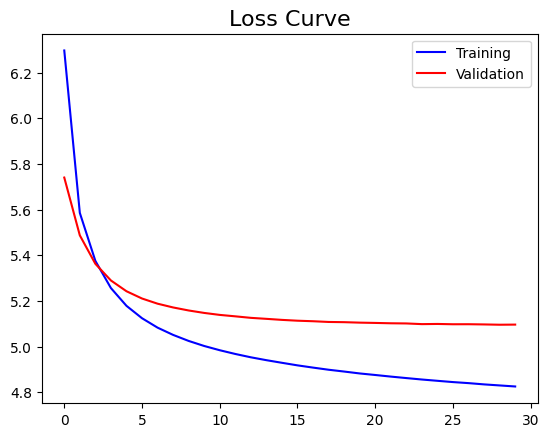

In [8]:
plt.plot(training_loss, color='b', label='Training')
plt.plot(validation_loss, color='r', label="Validation")
plt.title("Loss Curve", size=16)
plt.legend()

In [9]:
# ppl = evaluate_perplexity(model, metrics['perp'], test_loader, device)
# print("perplexity", ppl)

#        bleu = evaluate_perplexity(model, metrics['bleu'], test_loader, device) 
#        print("bleu", bleu)

print(model.prompt('Alice?', argm=False))

yes, the old, he was a very goodbye to be a great, and in the other; and in his face, and the other. the man who, but it was, he had been the first of the door, the old man
